[ARIMA] Intl AIC: 966.76
[ARIMA] Dom  AIC: 1154.17

[INTL ARIMA] Hold-out accuracy
     RMSE: 62.383
      MAE: 56.752
    MAPE%: 1.465
   sMAPE%: 1.473

Forecast results saved to: ../output/Model_01_ARIMA_TECT_AnnualSpend_international.csv


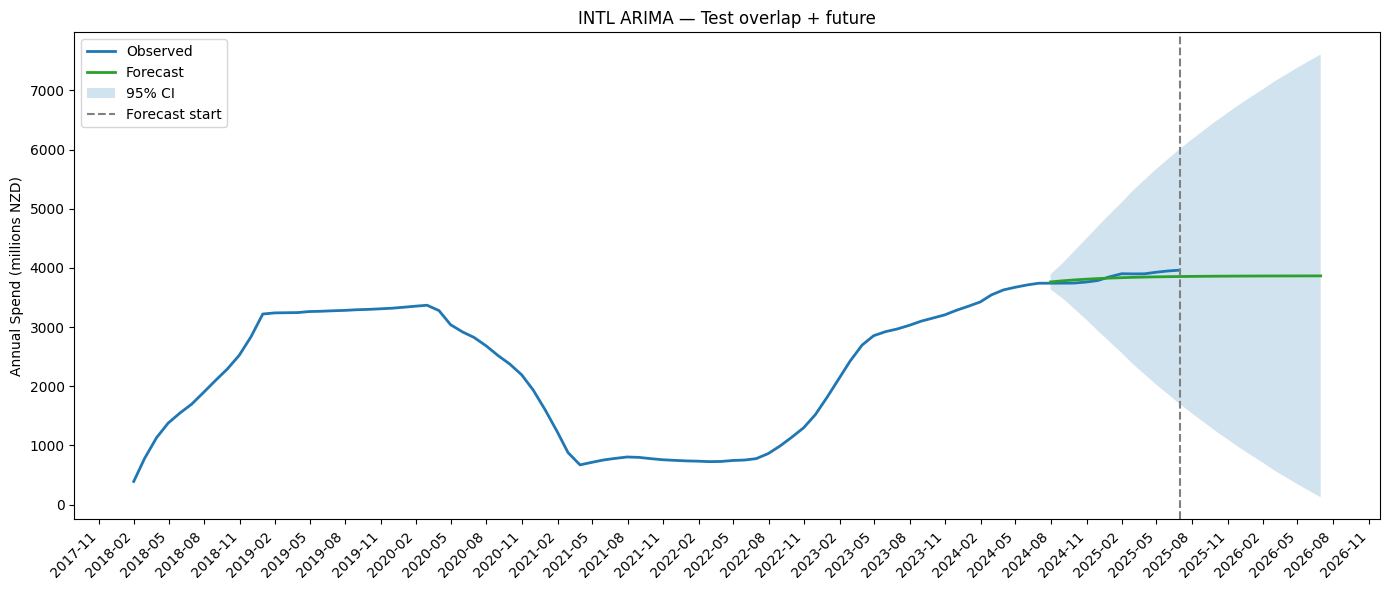


[DOM  ARIMA] Hold-out accuracy
     RMSE: 199.647
      MAE: 185.544
    MAPE%: 1.662
   sMAPE%: 1.646

Forecast results saved to: ../output/Model_01_ARIMA_TECT_AnnualSpend_domestic.csv


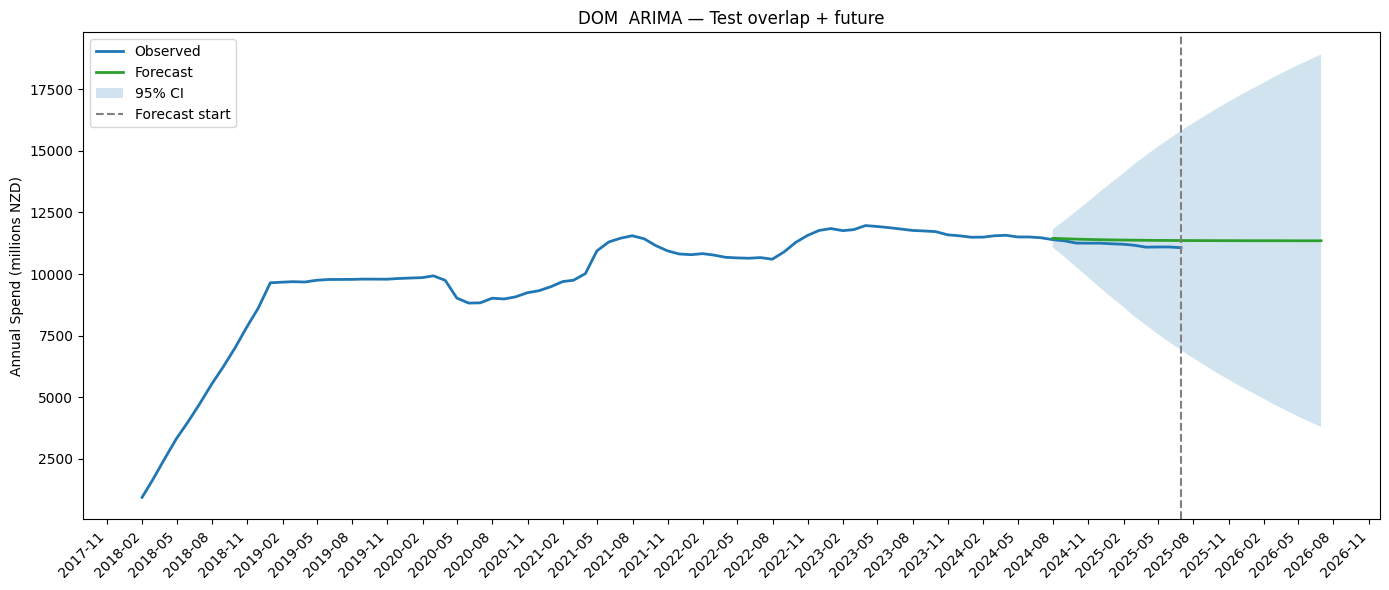

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.tseries.offsets import MonthEnd
from statsmodels.tsa.arima.model import ARIMA

# ----------------------- Config -----------------------
TECT_REGION_PATH = "../datasets/TECT/Region-series.csv"
FORECAST_STEPS = 12   # future horizon (after test)
HOLDOUT_STEPS  = 12   # test window length
ARIMA_ORDER    = (1, 1, 1)

# ----------------------- Helpers -----------------------
def _end_of_month_index(s: pd.Series) -> pd.DatetimeIndex:
    return pd.to_datetime(s) + MonthEnd(0)

def _full_month_range(idx: pd.Series) -> pd.DatetimeIndex:
    idx_eom = _end_of_month_index(idx)
    return pd.date_range(start=idx_eom.min(), end=idx_eom.max(), freq="M")

def _configure_ax(ax):
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

def _metrics(y_true: pd.Series, y_pred: pd.Series) -> dict:
    y_true, y_pred = y_true.astype(float), y_pred.astype(float)
    err  = y_true - y_pred
    rmse = float(np.sqrt(np.mean(err**2)))
    mae  = float(np.mean(np.abs(err)))
    denom = y_true.replace(0, np.nan)
    mape = float(np.mean(np.abs(err) / denom) * 100.0)
    smape = float(100.0 * np.mean(2 * np.abs(err) / (np.abs(y_true) + np.abs(y_pred) + 1e-12)))
    return {"RMSE": rmse, "MAE": mae, "MAPE%": mape, "sMAPE%": smape}

def _print_metrics(title: str, m: dict):
    print(f"\n[{title}] Hold-out accuracy")
    print(f"     RMSE: {m['RMSE']:.3f}")
    print(f"      MAE: {m['MAE']:.3f}")
    print(f"    MAPE%: {m['MAPE%']:.3f}" if np.isfinite(m["MAPE%"]) else "    MAPE%: nan")
    print(f"   sMAPE%: {m['sMAPE%']:.3f}" if np.isfinite(m["sMAPE%"]) else "   sMAPE%: nan")

# ----------------------- Data prep -----------------------
def load_data() -> pd.DataFrame:
    tect = pd.read_csv(TECT_REGION_PATH, parse_dates=["Date"])
    tect["Date"] = tect["Date"] + MonthEnd(0)
    tect = tect.sort_values("Date").rename(
        columns={"Visitor Type": "VisitorType", "Annual Spend": "AnnualSpend", "Monthly Spend": "MonthlySpend"}
    )
    return tect

def build_series(tect: pd.DataFrame):
    all_months = _full_month_range(tect["Date"])

    def _agg(col_vtype: str) -> pd.Series:
        return (
            tect[tect["VisitorType"] == col_vtype]
            .groupby("Date")["AnnualSpend"]
            .sum()
            .reindex(all_months)
            .fillna(0.0)
            .astype("float64")
        )

    intl_y = _agg("International")
    dom_y  = _agg("New Zealand")
    return intl_y, dom_y

# ----------------------- ARIMA Modeling -----------------------
def fit_arima(y: pd.Series):
    mod = ARIMA(endog=y, order=ARIMA_ORDER, enforce_stationarity=False, enforce_invertibility=False)
    return mod.fit()

def evaluate_and_plot_holdout_arima(
    y: pd.Series,
    k_test: int,
    h_future: int,
    title_prefix: str,
    model_label: str = "ARIMA",
    out_csv_base: str = "../output/Model_01_ARIMA_TECT_AnnualSpend.csv",
    out_suffix: str = ""
):
    if len(y) <= k_test + 24:
        print(f"[{title_prefix}] Skipping hold-out (series too short for k={k_test}).")
        return

    y_train, y_test = y.iloc[:-k_test], y.iloc[-k_test:]

    res = ARIMA(endog=y_train, order=ARIMA_ORDER, enforce_stationarity=False, enforce_invertibility=False).fit()

    steps_all = k_test + max(h_future, 0)
    fc_all    = res.get_forecast(steps=steps_all)
    y_pred_all = fc_all.predicted_mean
    ci_all     = fc_all.conf_int()

    start_next = y_train.index[-1] + MonthEnd(1)
    fc_index   = pd.date_range(start=start_next, periods=steps_all, freq="M")
    y_pred_all.index = fc_index
    ci_all.index     = fc_index

    y_pred_test = y_pred_all.iloc[: len(y_test)]
    mets = _metrics(y_test, y_pred_test)
    _print_metrics(title_prefix, mets)

    # === save per-series CSV ===
    out_csv = "../output/Model_01_ARIMA_TECT_AnnualSpend"
    out_csv = str(f"{out_csv}_{model_label.lower()}.csv")

    df_out = pd.DataFrame(
        {
            "Observed": y.reindex(y_pred_all.index),
            "Forecast": y_pred_all,
            "Lower_CI": ci_all.iloc[:, 0],
            "Upper_CI": ci_all.iloc[:, 1],
            "Model": model_label,
        }
    )
    df_out.index.name = "Date"
    df_out.to_csv(out_csv)
    print(f"\nForecast results saved to: {out_csv}")

    plt.figure(figsize=(14, 6))
    plt.plot(y.index, y.values, label="Observed", color="tab:blue", linewidth=2)
    plt.plot(y_pred_all.index, y_pred_all.values, label="Forecast", color="tab:green", linewidth=2)
    plt.fill_between(ci_all.index, ci_all.iloc[:, 0].values, ci_all.iloc[:, 1].values, alpha=0.2, label="95% CI")
    plt.axvline(y_test.index[-1], color="gray", linestyle="--", label="Forecast start")
    plt.title(f"{title_prefix} — Test overlap + future")
    plt.ylabel("Annual Spend (millions NZD)")
    plt.legend()
    _configure_ax(plt.gca())
    plt.tight_layout()
    plt.show()

def main_arima():
    tect = load_data()
    intl_y, dom_y = build_series(tect)

    res_intl = fit_arima(intl_y)
    res_dom  = fit_arima(dom_y)
    print(f"[ARIMA] Intl AIC: {res_intl.aic:.2f}")
    print(f"[ARIMA] Dom  AIC: {res_dom.aic:.2f}")

    out_base = "../output/Model_01_ARIMA_TECT_AnnualSpend.csv"
    evaluate_and_plot_holdout_arima(
        intl_y, HOLDOUT_STEPS, FORECAST_STEPS,
        "INTL ARIMA", model_label="International",
        out_csv_base=out_base, out_suffix="_intl"
    )
    evaluate_and_plot_holdout_arima(
        dom_y,  HOLDOUT_STEPS, FORECAST_STEPS,
        "DOM  ARIMA", model_label="Domestic",
        out_csv_base=out_base, out_suffix="_dom"
    )
if __name__ == "__main__":
    main_arima()
